# History Kaggle: Airbnb New User Bookings

## Download data
Data for this project are downloaded from the following link:<br/>
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

I learn from script posts:
1. https://www.kaggle.com/kevinwu06/airbnb-exploratory-analysis\
2. https://www.kaggle.com/davidgasquez/user-data-exploration

Format follow:
https://github.com/udacity/machine-learning/blob/master/projects/capstone/capstone_report_template.md

## Data Exploration

We are given users information (train_users.csv, test_users.csv), records of users' web sessions (sessions.csv) as well as some other related information (age_gender_bkts.csv, countries.csv) as input datasets.

In the cells below, I'll load each one of the dataset and discuss features, calculate statistics, and note any missing values or outliers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import datetime

# import warnings
# warnings.filterwarnings('ignore')    # suppress warnings for clean demo

pd.set_option('display.max_rows', None)    #don't hide any rows or columns when display
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV

### Load Datasets (5 files in total)

#### Users dataset (2 files)

In [2]:
train_users_data = pd.read_csv("train_users_2.csv")
test_users_data = pd.read_csv("test_users.csv")

In [3]:
num_rows_train, num_cols_train = train_users_data.shape
print("There are {:,} rows and {:,} columns in the train_users data.".format(num_rows_train, num_cols_train))
num_rows_test, num_cols_test = test_users_data.shape
print("There are {:,} rows and {:,} columns in the test_users data.".format(num_rows_test, num_cols_test))

There are 213,451 rows and 16 columns in the train_users data.
There are 62,096 rows and 15 columns in the test_users data.


In [4]:
train_users_data.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [5]:
test_users_data.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome


In [6]:
# check that id is the unique label for data
train_users_data.id.unique().shape[0] == train_users_data.shape[0], test_users_data.id.unique().shape[0] == test_users_data.shape[0]

(True, True)

In [7]:
train_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [8]:
test_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [9]:
print("Percentage of missing age value in training data: {:.2f}%".format(sum(train_users_data.age.isnull())/num_rows_train * 100.))
print("Percentage of missing age value in testing data: {:.2f}%".format(sum(test_users_data.age.isnull())/num_rows_test * 100.))

Percentage of missing age value in training data: 41.22%
Percentage of missing age value in testing data: 46.50%


In [10]:
print("There are {} unique values in signup_flow column in training data.".format(len(train_users_data.signup_flow.unique())))
print("There are {} unique values in signup_flow column in testing data.".format(len(test_users_data.signup_flow.unique())))
print("There are {} unique values in signup_flow column in all data.".format(len(np.unique(train_users_data.signup_flow.unique().tolist() + test_users_data.signup_flow.unique().tolist()))))

There are 17 unique values in signup_flow column in training data.
There are 7 unique values in signup_flow column in testing data.
There are 18 unique values in signup_flow column in all data.


*Findings:*
- *Most of the columns are categorical variable.* 
- *We will transform `date_account_created` and `timestamp_first_active` into date-time format.*
- *`Age` has a lot of missing values.*

#### User Web Sessions Record (1 file)

Sessions file contains, for each user_id, the action, action type, action detail, device type and the time elapsed from the previous action. The sessions data goes back to Jan 1, 2014 which is only a small recent portion of the users data that dates back to 2010. 

In [11]:
sessions_data = pd.read_csv("sessions.csv")

In [13]:
num_rows_sessions, num_cols_sessions = sessions_data.shape
print("There are {:,} rows and {:,} columns in the sessions data".format(num_rows_sessions, num_cols_sessions))

There are 10,567,737 rows and 6 columns in the sessions data


In [14]:
# number of unique elements
sessions_data.nunique(dropna = False)

user_id          135484
action              360
action_type          11
action_detail       156
device_type          14
secs_elapsed     337662
dtype: int64

In [15]:
# check records for one user_id
sessions_data[sessions_data.user_id == sessions_data.user_id[0]]

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [16]:
# remove rows with id that's not in training or testing data set
id_train_test = set(sessions_data.user_id.unique()) & (set(train_users_data.id.unique()) | set(test_users_data.id.unique()))
set(sessions_data.user_id.unique()) - id_train_test

{nan}

In [17]:
sessions_data = sessions_data[sessions_data.user_id.notnull()]

In [18]:
missing_df = sessions_data.isnull().sum().reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df

,column_name,missing_count
0,user_id,0
1,action,79480
2,action_type,1122957
3,action_detail,1122957
4,device_type,0
5,secs_elapsed,135483


Finding: The number of missing values in column `secs_elapsed` is the same as the number of unique user_id. Note that the definition of `secs_elapsed` is the time elapsed since the last action of a user in the unit of seconds. A possible explanation for missing value is that it corresponds to the first action from a user.

In [19]:
sessions_data.action.unique()

array(['lookup', 'search_results', 'personalize', 'index',
       'similar_listings', 'ajax_refresh_subtotal', 'show',
       'header_userpic', 'ask_question', nan,
       'other_hosting_reviews_first', 'hosting_social_proof',
       'decision_tree', 'recent_reservations', 'faq_experiment_ids',
       'multi', 'active', 'dashboard', 'create', 'confirm_email',
       'show_personalize', 'verify', 'pending', 'requested', 'concierge',
       'faq', 'clear_reservation', 'cancellation_policies',
       'track_page_view', 'update', 'my', 'campaigns', 'notifications',
       'listings', 'unavailabilities', 'ajax_lwlb_contact',
       'ajax_check_dates', 'qt2', 'request_new_confirm_email',
       'ajax_photo_widget_form_iframe', 'facebook_auto_login', 'identity',
       'qt_reply_v2', 'travel_plans_current', 'complete_status',
       'populate_from_facebook', 'kba_update', 'kba', 'login',
       'authenticate', 'calendar_tab_inner2', 'other_hosting_reviews',
       'social_connections', 'relat

In [20]:
sessions_data.secs_elapsed.describe()

count    1.039776e+07
mean     1.941124e+04
std      8.890920e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.146000e+03
75%      8.442000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


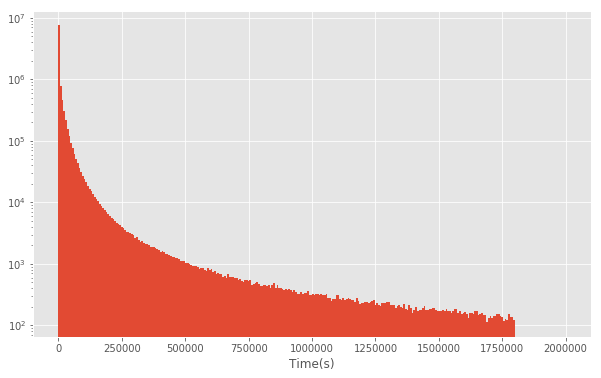

In [29]:
# gamma regression?
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(sessions_data.secs_elapsed, range = (0, 2000000), bins = 300, log = True);
ax.set_xlabel('Time(s)');

In [21]:
action_counts = sessions_data.user_id.value_counts()

In [22]:
action_counts.head(3)

mxqbh3ykxl    2722
0hjoc5q8nf    2644
mjbl6rrj52    2476
Name: user_id, dtype: int64

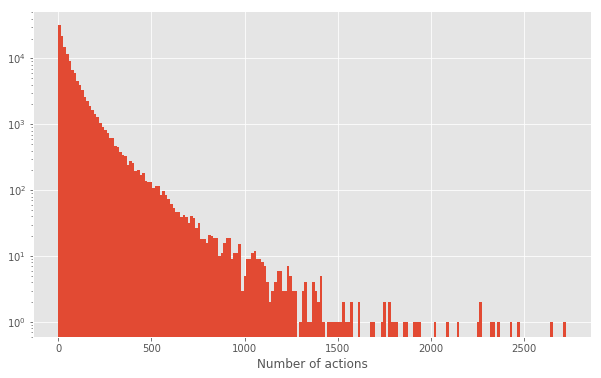

In [33]:
# plot histogram of total number of actions per user
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(action_counts, bins = 200, log = True);
ax.set_xlabel('Number of actions');

In [24]:
# number of users in the training dataset, percentage of training users that has sessions info
len(set(train_users_data.id.unique())), len(set(action_counts.index.values) & set(train_users_data.id.unique()))/len(set(train_users_data.id.unique()))

(213451, 0.34581707277079987)

In [25]:
# number of users in the testing dataset, percentage of testing users that has sessions info
len(set(test_users_data.id.unique())), len(set(action_counts.index.values) & set(test_users_data.id.unique()))/len(set(test_users_data.id.unique()))

(62096, 0.9931074465343983)

#### Supplementary dataset: Age, Gender Statistics (1 file)

This file contains the census data of age and gender distribution for the 10 destination countries as of 2015.

In [36]:
age_gender_bkts_data = pd.read_csv("age_gender_bkts.csv")

In [37]:
num_rows_age, num_cols_age = age_gender_bkts_data.shape
print("There are {} rows and {} columns in the age_gender_bkts data".format(num_rows_age, num_cols_age))

There are 420 rows and 5 columns in the age_gender_bkts data


In [38]:
age_gender_bkts_data.year.unique()

array([ 2015.])

In [39]:
age_gender_bkts_data.country_destination.unique()

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US'], dtype=object)

In [40]:
age_gender_bkts_data.head(3)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0


####  Supplementary dataset: Country Information (1 file)

This file contains the latitude, longitude, distance to US, area, and language of 10 destination countries.

In [41]:
countries_data = pd.read_csv("countries.csv")

In [42]:
num_rows_country, num_cols_country = countries_data.shape
print("There are {} rows and {} columns in the countries data".format(num_rows_country, num_cols_country))

There are 10 rows and 7 columns in the countries data


In [43]:
countries_data.head(3)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61


In [44]:
countries_data.country_destination.unique()

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US'], dtype=object)

### Exploratory Visualization

#### The `Age` column of user demographics

/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


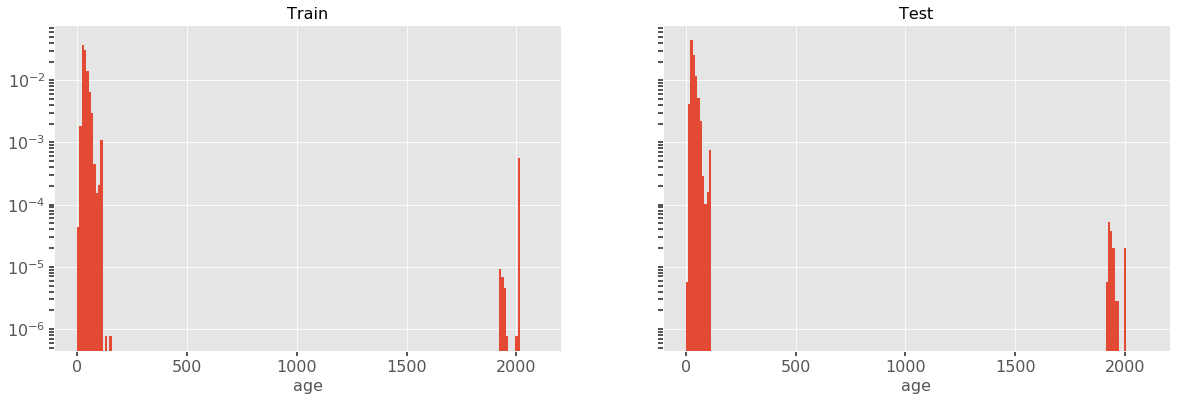

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6), sharex = True, sharey = True)
ax[0].hist(train_users_data.age, range = (0, 2100), log = True, bins = 200, normed = True);
ax[0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[0].set_title('Train', fontsize = 16);
ax[0].set_xlabel('age', fontsize = 16);
ax[1].hist(test_users_data.age, range = (0, 2100), log = True, bins = 200, normed = True);
ax[1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out');
ax[1].set_title('Test', fontsize = 16);
ax[1].set_xlabel('age', fontsize = 16);

/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


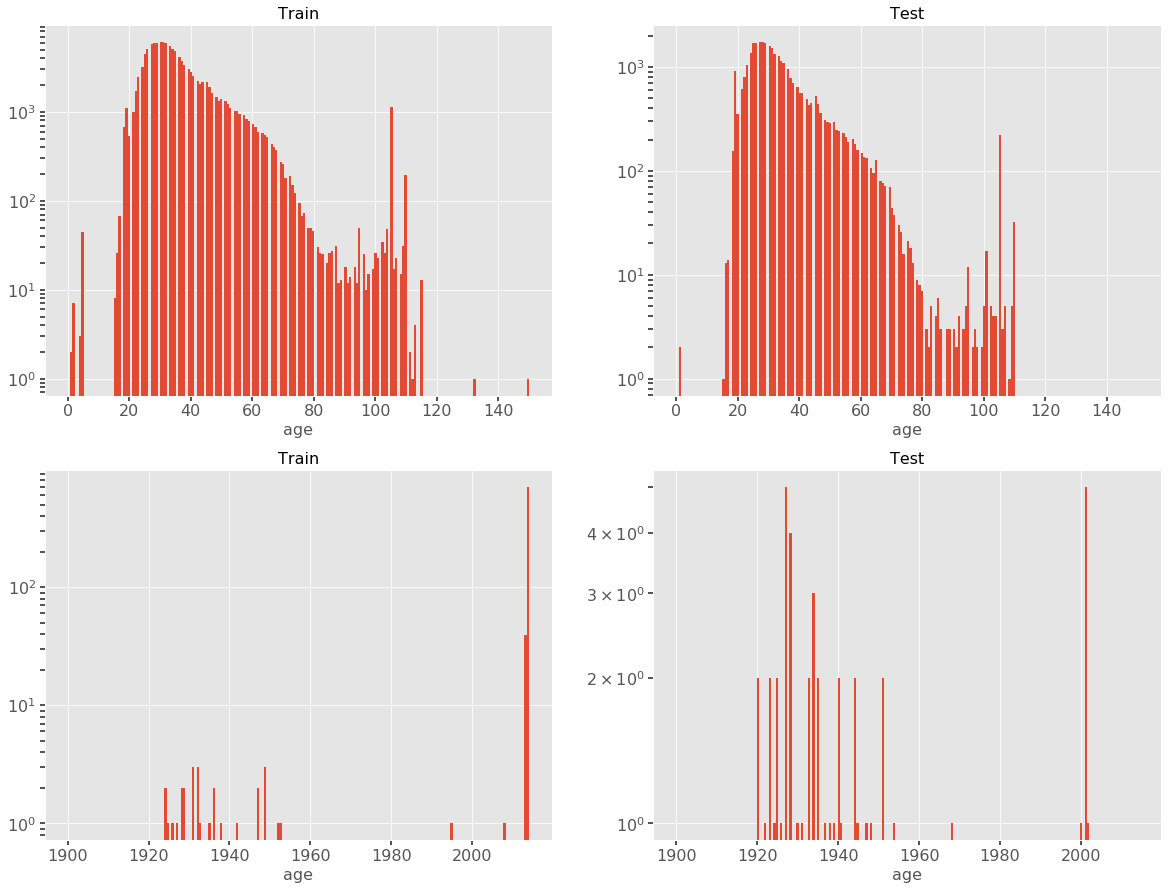

In [46]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 15))
ax[0, 0].hist(train_users_data.age, range = (0, 150), log = True, bins = 200);
ax[0, 0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out')
ax[0, 0].set_title('Train', fontsize = 16);
ax[0, 0].set_xlabel('age', fontsize = 16);
ax[0, 1].hist(test_users_data.age, range = (0, 150), log = True, bins = 200);
ax[0, 1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out')
ax[0, 1].set_title('Test', fontsize = 16);
ax[0, 1].set_xlabel('age', fontsize = 16);
ax[1, 0].hist(train_users_data.age, range = (1900, 2014), log = True, bins = 200);
ax[1, 0].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out')
ax[1, 0].set_title('Train', fontsize = 16);
ax[1, 0].set_xlabel('age', fontsize = 16);
ax[1, 1].hist(test_users_data.age, range = (1900, 2014), log = True, bins = 200);
ax[1, 1].tick_params(axis='both',which='both',labelsize=16,\
        length=5,width=2,direction='out')
ax[1, 1].set_title('Test', fontsize = 16);
ax[1, 1].set_xlabel('age', fontsize = 16);

*Note: In addition to missing values in the datasets, there are illegal values for age. I would take age range larger than 14 and smaller than 100 as the legal range for users on Airbnb. I will treat other age same as missing. Then I would convert the age into buckets with 5-year spans.*

#### Distribution of each feature in training data by `country_destination`

##### Basic summary of  `country_destination`

In [47]:
train_users_data['country_destination'].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

*Finding: A little more than half of the users in the training dataset don't have a booking (`NDF`). Out of the ones that have a booking, more than half have `US` as their destination.*

##### `age` & `country_destination`

In [48]:
train_users_data.loc[:,['age', 'country_destination']].groupby('country_destination').describe()

age                                                  \
                       count       mean         std   min   25%   50%    75%   
country_destination                                                            
AU                     436.0  42.807339   95.623926  18.0  29.0  35.0  44.00   
CA                    1077.0  48.990715  147.787977  18.0  29.0  34.0  43.00   
DE                     851.0  53.545241  179.178672   5.0  28.0  34.0  43.00   
ES                    1706.0  46.236811  143.981508   2.0  27.0  32.0  40.00   
FR                    3713.0  48.114193  141.413494   5.0  29.0  34.0  44.00   
GB                    1774.0  50.163472  148.662233   5.0  29.0  35.0  46.00   
IT                    2036.0  50.645383  158.148905   4.0  28.0  34.0  44.00   
NDF                  56929.0  51.830034  166.491430   1.0  28.0  34.0  44.00   
NL                     602.0  53.151163  180.132976  18.0  28.0  33.0  41.00   
PT                     158.0  48.746835  157.870702  19.0  28.0  32.0  41.75   
US                   48603.0  47.414727  144.266312   2.0  28.0  33.0  41.00   
other                 7576.0  48.836325  150.762355   2.0  29.0  34.0  42.00   

                             
                        max  
country_destination          
AU                   2014.0  
CA                   2014.0  
DE                   2014.0  
ES                   2014.0  
FR                   2014.0  
GB                   2014.0  
IT                   2014.0  
NDF                  2014.0  
NL                   2014.0  
PT                   2014.0  
US                   2014.0  
other                2014.0

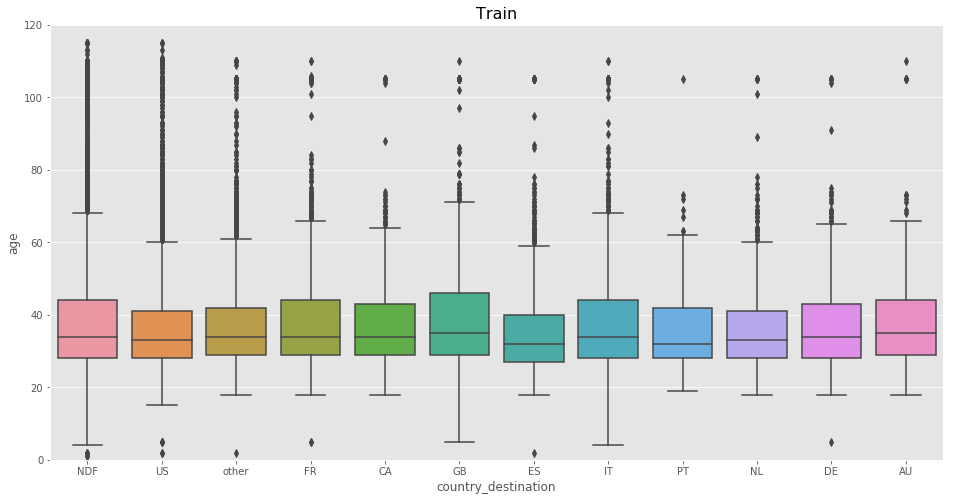

In [49]:
fig, ax = plt.subplots(figsize = (16, 8))
sns.boxplot(x = 'country_destination', y = 'age', data = train_users_data);
ax.set_ylim((0, 120));
ax.set_title('Train', fontsize = 16);

*Finding: Median ages for 12 destination countries are similar. There are more large age outliers than low age outliers according to the 1.5 x IQR above / below 3rd quartile or 1st quartile rule.*

#### Categorical features & `country_destination`

Description:
- signup_flow: the page a user came to signup up from. (There's no more information on what each number refers to specifically).
- language: international language preference
- affiliate_channel: what kind of paid marketing
- affiliate_provider: where the marketing is e.g. google, craigslist, other
- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
- signup_app
- first_device_type
- first_browser

In [50]:
cat_features = train_users_data.columns.tolist()
cat_features = [i for i in cat_features if i not in ('country_destination', 'id', 'age', 'date_account_created', 'timestamp_first_active', 'date_first_booking')]
print(cat_features)

['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']


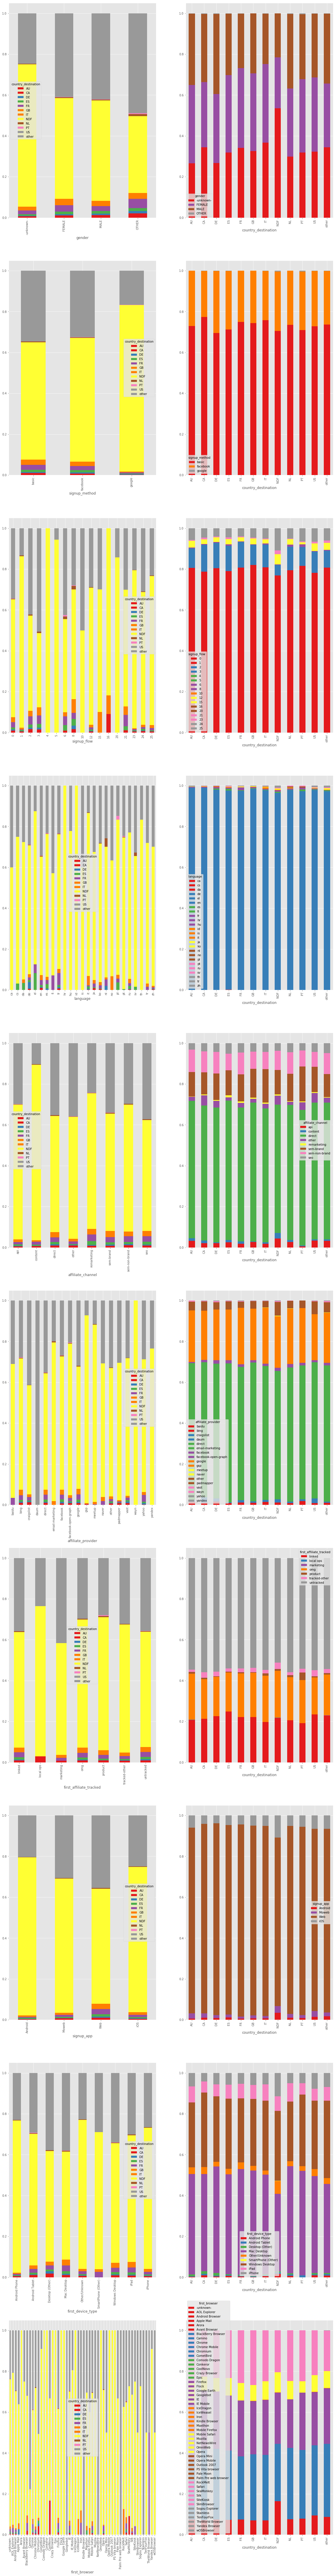

In [51]:
bar_order = train_users_data['country_destination'].value_counts().index.tolist()
fig = plt.figure(figsize = (20, 160));
i = 1
for feat in cat_features:
    cross_tab = pd.crosstab(train_users_data.country_destination, [train_users_data.loc[:,feat]])
    ax = fig.add_subplot(len(cat_features), 2, (i - 1) * 2 + 1);
    tmp = pd.crosstab([train_users_data.loc[:,feat]], train_users_data.country_destination).apply(lambda x: x/x.sum(), axis=1)
    tmp.plot(kind='bar', stacked=True, ax = ax, legend = True, colormap = 'Set1');
    ax = fig.add_subplot(len(cat_features), 2, (i - 1) * 2 + 2);
    tmp = pd.crosstab(train_users_data.country_destination, [train_users_data.loc[:,feat]]).apply(lambda x: x/x.sum(), axis=1)
    tmp.plot(kind='bar', stacked=True, ax = ax, legend = True, colormap = 'Set1');
    i += 1

*Finding: There are many different categories of `first_browser` which might be useful to combine some of the less frequently used ones into a sub-category. Another idea is to group `first_device_type` into desktop/mobile devices.*

#### Datetime features & `country_destination`

In [53]:
train_users_data.loc[:,'date_account_created'] = pd.to_datetime(train_users_data.date_account_created)
test_users_data.loc[:,'date_account_created'] = pd.to_datetime(test_users_data.date_account_created)

In [54]:
train_users_data.loc[:,'timestamp_first_active'] = pd.to_datetime(train_users_data.timestamp_first_active.apply(str))
test_users_data.loc[:,'timestamp_first_active'] = pd.to_datetime(test_users_data.timestamp_first_active.apply(str))

In [62]:
# start time of `timestamp_first_active` in training data and testing data
min(train_users_data.timestamp_first_active), min(test_users_data.timestamp_first_active)

(Timestamp('2009-03-19 04:32:55'), Timestamp('2014-07-01 00:00:06'))

In [63]:
# start time of `date_account_created` in training data and testing data
min(train_users_data.date_account_created), min(test_users_data.date_account_created)

(Timestamp('2010-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

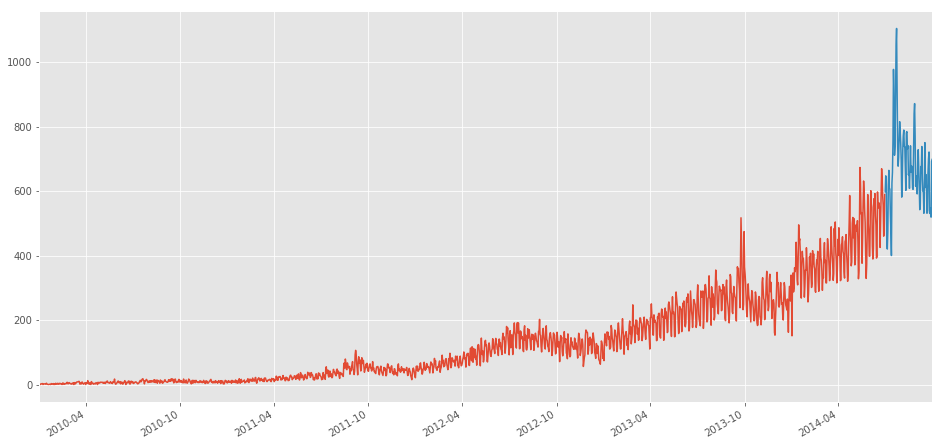

In [55]:
# convert `date_account_created` column into datetime format before running this cell
fig, ax = plt.subplots(figsize = (16, 8));
train_users_data.date_account_created.value_counts().plot();
test_users_data.date_account_created.value_counts().plot();

*Finding: The account creation dates of testing dataset users are later in time than those of training dataset users. One can't apply cross-validation technique to time-series data. However, we are going to assume that users of Airbnb are independent and not treat it like a time-series data.*

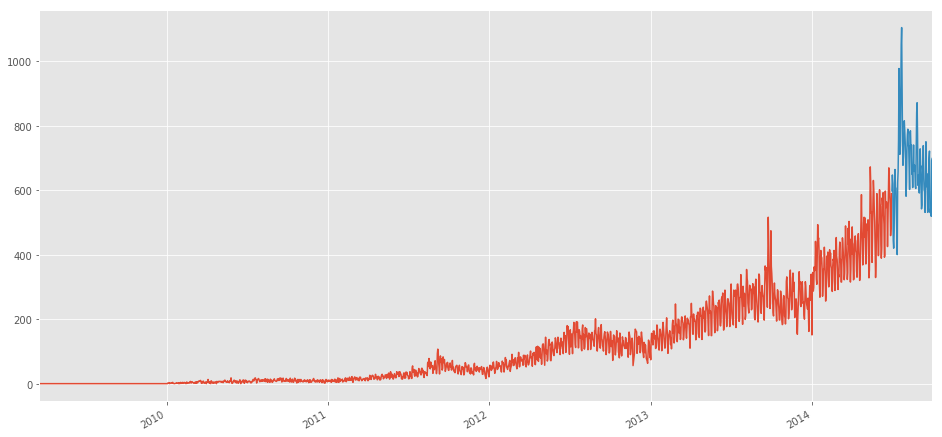

In [56]:
%%time
# convert `timestamp_first_active` column into string then to datetime format before running this cell
# %x retrieves date year/month/date, there's information about hour, minute, second as well
fig, ax = plt.subplots(figsize = (16, 8));
train_users_data.timestamp_first_active.apply(lambda x: pd.to_datetime(x.strftime('%x'))).value_counts().plot();
test_users_data.timestamp_first_active.apply(lambda x: pd.to_datetime(x.strftime('%x'))).value_counts().plot();

*Finding: The `timestamp_first_active` follow similar trend as `data_account_created` above and in theory its value could be earlier than `date_account_created`. One interesting quantity to look at is the time difference between the two quantities.*

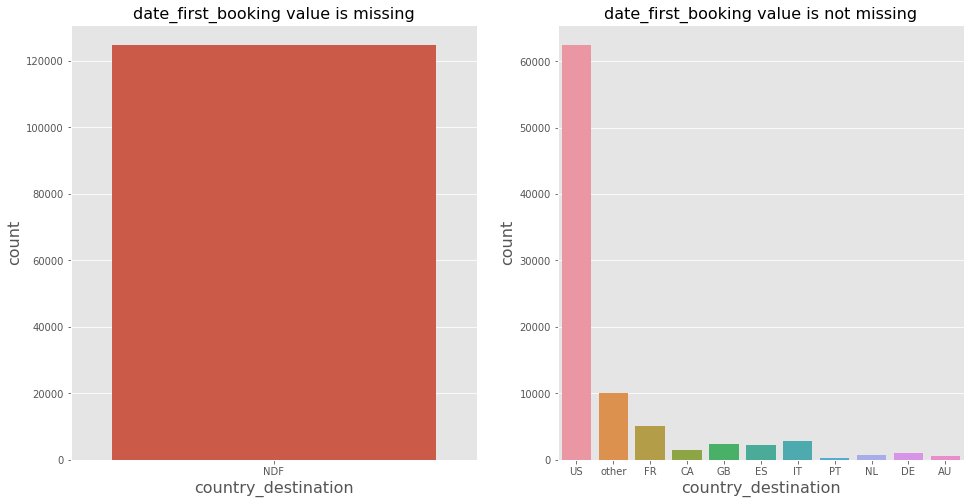

In [57]:
index_tmp = train_users_data.date_first_booking.isnull()
fig, ax = plt.subplots(ncols = 2, figsize = (16, 8));
sns.countplot(train_users_data[index_tmp].country_destination, ax = ax[0]);
ax[0].set_title('date_first_booking value is missing', fontsize = 16);
ax[0].set_xlabel('country_destination', fontsize = 16);
ax[0].set_ylabel('count', fontsize = 16);
sns.countplot(train_users_data[~index_tmp].country_destination, ax = ax[1]);
ax[1].set_title('date_first_booking value is not missing', fontsize = 16);
ax[1].set_xlabel('country_destination', fontsize = 16);
ax[1].set_ylabel('count', fontsize = 16);

In [58]:
# values in the `date_first_booking` column in the testing data set
test_users_data.date_first_booking.unique()

array([ nan])

*Finding: Values of `date_first_booking` for users with no destination yet are missing. This makes sense because there will only be a value for `date_first_booking` after there's a booking. Therefore I will not use this feature for building the prediction model since all the values in this columns is not available for the testing dataset.*

### Data Preprocessing

#### Label encode `country_destination`

In [60]:
label_encoder = LabelEncoder()
train_users_data['country_destination'] = label_encoder.fit_transform(train_users_data['country_destination'])
country_code_map=dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [61]:
# map between country and its code
country_code_map

{'AU': 0,
 'CA': 1,
 'DE': 2,
 'ES': 3,
 'FR': 4,
 'GB': 5,
 'IT': 6,
 'NDF': 7,
 'NL': 8,
 'PT': 9,
 'US': 10,
 'other': 11}

#### Combine train & test data to preprocess together

In [85]:
id_test = test_users_data['id']
train_users_data.drop(['country_destination', 'date_first_booking', 'id'], axis = 1, inplace = True)
test_users_data.drop(['date_first_booking','id'], axis = 1, inplace = True)

In [138]:
full_data = pd.concat([train_users_data, test_users_data], axis = 0, ignore_index = True)

#### Convert the continuous `Age` into categories

In [139]:
# set age outside of valid age range (10, 100] to nan
valid_age_index = full_data.age.apply(lambda x: 10 < x <= 100)
full_data.loc[~valid_age_index, 'age'] = np.nan

In [140]:
# pd.cut has the convention that 30 belongs to 25-29, but 25 doesn't  
age_bins = np.arange(10., 105., 5.).tolist()
age_names = list(reversed(age_gender_bkts_data.age_bucket.unique()))[2:-1]
full_data['age_bucket_col'] = pd.cut(full_data.age, age_bins, labels = age_names)

In [141]:
full_data.head(5)

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_bucket_col
0,2010-06-28,2009-03-19 04:32:55,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN
1,2011-05-25,2009-05-23 17:48:09,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,35-39
2,2010-09-28,2009-06-09 23:12:47,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,55-59
3,2011-12-05,2009-10-31 06:01:29,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,40-44
4,2010-09-14,2009-12-08 06:11:05,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,40-44


#### Add features engineered using `sessions` data